### Visualize the boundary condition forcing file

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib
import cmocean
from matplotlib.patches import ConnectionPatch
from math import sin, cos, sqrt, atan2, radians

%matplotlib inline

Plot settings

In [3]:
land_color = '#a9a7a2'

Model dimensions etc.

In [4]:
mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb.nc')
mesh_lon     = np.array(mesh.variables['nav_lon'])
mesh_lat     = np.array(mesh.variables['nav_lat'])
mesh_bathy   = np.array(mesh.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = np.array(mesh.variables['nav_lev'])

In [5]:
imin, imax = 160, 800
jmin, jmax = 1100, 2180

Boundary Condition file:

In [6]:
rimwidthN = 10; rimwidthS = 10; rimwidthE = 20; rimwidthSE = 20; rimwidthW = 10;

In [7]:
BC = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Pb_OBC-20210302.nc', 'r')
dPb_N = np.array(BC.variables['dPb_N']).reshape(50,10,407)
dPb_S = np.array(BC.variables['dPb_S']).reshape(50,10,239)
dPb_E = np.array(BC.variables['dPb_E']).reshape(50,20,579)
dPb_SE = np.array(BC.variables['dPb_SE']).reshape(50,20,35)
dPb_W = np.array(BC.variables['dPb_W']).reshape(50,10,284)

In [8]:
dPb_N_lons = mesh_lon[jmax-rimwidthN:jmax, 392:imax-1] 
dPb_N_lats = mesh_lat[jmax-rimwidthN:jmax, 392:imax-1]
dPb_N_mdepths = bathy_masked[:,jmax-rimwidthN:jmax, 392:imax-1] 

dPb_S_lons = mesh_lon[jmin:jmin+rimwidthS,441:680] 
dPb_S_lats = mesh_lat[jmin:jmin+rimwidthS,441:680]
dPb_S_mdepths = bathy_masked[:,jmin:jmin+rimwidthS,441:680]

dPb_E_lons = mesh_lon[1601:jmax,imax-1-rimwidthE:imax-1] 
dPb_E_lats = mesh_lat[1601:jmax,imax-1-rimwidthE:imax-1] 
dPb_E_mdepths = bathy_masked[:,1601:jmax,imax-1-rimwidthE:imax-1] 

dPb_SE_lons = mesh_lon[jmin:jmin+35,680-rimwidthSE:680] 
dPb_SE_lats = mesh_lat[jmin:jmin+35,680-rimwidthSE:680] 
dPb_SE_mdepths = bathy_masked[:,jmin:jmin+35,680-rimwidthSE:680] 

dPb_W_lons = mesh_lon[1190:1474,292:292+rimwidthW] 
dPb_W_lats = mesh_lat[1190:1474,292:292+rimwidthW] 
dPb_W_mdepths = bathy_masked[:,1190:1474,292:292+rimwidthW] 

In [9]:
print('Northern boundary dimensions: ', dPb_N.shape, dPb_N_lons.shape, dPb_N_lats.shape, dPb_N_mdepths.shape)
print('Eastern boundary dimensions: ', dPb_E.shape, dPb_E_lons.shape, dPb_E_lats.shape, dPb_E_mdepths.shape)
print('Southern boundary dimensions: ', dPb_S.shape, dPb_S_lons.shape, dPb_S_lats.shape, dPb_S_mdepths.shape)
print('Southeastern boundary dimensions: ', dPb_SE.shape, dPb_SE_lons.shape, dPb_SE_lats.shape, dPb_SE_mdepths.shape)
print('Western boundary dimensions: ', dPb_W.shape, dPb_W_lons.shape, dPb_W_lats.shape, dPb_W_mdepths.shape)

Northern boundary dimensions:  (50, 10, 407) (10, 407) (10, 407) (50, 10, 407)
Eastern boundary dimensions:  (50, 20, 579) (579, 20) (579, 20) (50, 579, 20)
Southern boundary dimensions:  (50, 10, 239) (10, 239) (10, 239) (50, 10, 239)
Southeastern boundary dimensions:  (50, 20, 35) (35, 20) (35, 20) (50, 35, 20)
Western boundary dimensions:  (50, 10, 284) (284, 10) (284, 10) (50, 284, 10)


Pb observations:

In [10]:
folder= '/ocean/brogalla/GEOTRACES/data/'

# North Atlantic
Pb_NA = nc.Dataset(folder+'GEOTRACES_IDP2017_v2_Discrete_Sample_Data_5024209a_1.nc', 'r')
NA_lats   = np.tile(Pb_NA.variables['latitude'], (288,1)).transpose()
NA_lons   = np.tile(Pb_NA.variables['longitude'], (288,1)).transpose()
NA_depths = np.array(Pb_NA.variables['var2'])
Pb_NA     = np.array(Pb_NA.variables['var5']) # in pmol/kg
mNA_Pb     = np.ma.masked_where(np.logical_or( Pb_NA > 1e5, Pb_NA < -1e5), Pb_NA).compressed()
mNA_depths = np.ma.masked_where(np.logical_or( Pb_NA > 1e5, Pb_NA < -1e5), NA_depths).compressed()
mNA_lons   = np.ma.masked_where(np.logical_or( Pb_NA > 1e5, Pb_NA < -1e5), NA_lons).compressed()
mNA_lons[mNA_lons > 180] = mNA_lons[mNA_lons > 180] - 360
mNA_lats   = np.ma.masked_where(np.logical_or( Pb_NA > 1e5, Pb_NA < -1e5), NA_lats).compressed()

# Arctic Ocean (from Rob Rember):
df = pd.read_csv(folder+'Pb_rob_rember.csv', parse_dates=['DATE']).dropna()
AO_depths = np.array(df['CTDDEPTH'])
AO_lats   = np.array(df['LATITUDE'])
AO_lons   = np.array(df['LONGITUDE'])
AO_dPb    = np.array(df['Pb_(pMol)'])

### Figure

In [11]:
def plot_BC(axis, location, xlim=(68, 80), ylim=(4000, -50), vlim=(0,25)):
    # --- axis is the plotting axis
    # --- location is one of "CB", "BB", "AO", or "BBE"
    # --- xlim is coordinate pair of lower and upper limit of x-axis
    # --- ylim is coordinate pair of lower and upper limit of y-axis
    
    axis.invert_yaxis()
    axis.set_xlim([xlim[0], xlim[1]])
    axis.set_ylim([ylim[0], ylim[1]])
    axis.tick_params(axis='both', which='major', labelsize=12)
    
    if location == 'CB': # Western Canada Basin
        dPb = dPb_N[:,-1,:]
        xx, zz = np.meshgrid(dPb_N_lats[-1,:], depths)
        bathy = dPb_N_mdepths[:,-1,:]
    elif location =='AO': #Northern Canada Basin
        dPb = dPb_E[:,-1,:]
        xx, zz = np.meshgrid(-1*dPb_E_lons[:,-1], depths)
        bathy = dPb_E_mdepths[:,:,-1]
    elif location == 'BB': # Labrador Sea
        dPb = dPb_S[:,-1,:]
        xx, zz = np.meshgrid(-1*dPb_S_lons[-1,:], depths)
        bathy = dPb_S_mdepths[:,-1,:]
    elif location == 'BBE': # Tip of Greenland
        dPb = dPb_SE[:,-1,:]
        xx, zz = np.meshgrid(dPb_SE_lats[:,-1], depths)
        bathy = dPb_SE_mdepths[:,:,-1]
    elif location == 'HB': # Hudson Bay
        dPb = dPb_W[:,-1,:]
        xx, zz = np.meshgrid(-1*dPb_W_lons[:,-1], depths)
        bathy = dPb_W_mdepths[:,:,-1]

    # Plot boundary condition:    
    if location == 'CB' or location == 'AO':
        CB = axis.pcolor(xx, zz, dPb*1e12, vmin=vlim[0], vmax=vlim[1], cmap=cmocean.cm.deep_r)
    else:
        CB = axis.pcolor(xx, zz, dPb*1e12, vmin=vlim[0], vmax=vlim[1], cmap=cmocean.cm.matter_r)
    axis.contourf(xx, zz, bathy, cmap=matplotlib.colors.ListedColormap([land_color]))
        
    # superimpose observations:
    if location == 'CB':
        axis.scatter(AO_lats[(AO_lats > 71) & (AO_lats < 75) & (AO_lons < -150)], \
                     AO_depths[(AO_lats > 71) & (AO_lats < 75) & (AO_lons < -150)],\
                     c=AO_dPb[(AO_lats > 71) & (AO_lats < 75) & (AO_lons < -150)], \
                     vmin=vmin_CS1, vmax=vmax_CS1, edgecolor='w', cmap=cmocean.cm.deep_r, s=100)
    elif location == 'AO':
        axis.scatter(-1*AO_lons[(AO_lats > 80) & (AO_lons > -150)], \
                     AO_depths[(AO_lats > 80) & (AO_lons > -150)], \
                     c =AO_dPb[(AO_lats > 80) & (AO_lons > -150)], \
                     vmin = vmin_CS1, vmax = vmax_CS1, edgecolor='w', cmap=cmocean.cm.deep_r, s=100)
        axis.scatter(-1*AO_lons[(AO_lats > 75) & (AO_lons < -150) & (AO_lons > -179)], \
                     AO_depths[(AO_lats > 75) & (AO_lons < -150) & (AO_lons > -179)], \
                     c =AO_dPb[(AO_lats > 75) & (AO_lons < -150) & (AO_lons > -179)], \
                     vmin = vmin_CS1, vmax = vmax_CS1, edgecolor='w', cmap=cmocean.cm.deep_r, s=100)
    elif location == 'BB':
        axis.scatter(-1*mNA_lons[(mNA_lats < 60) & (mNA_lats > 52) & (mNA_lons > -90) & (mNA_lons <-44)], \
                     mNA_depths[(mNA_lats < 60) & (mNA_lats > 52) & (mNA_lons > -90) & (mNA_lons <-44)], \
                     c=mNA_Pb[(mNA_lats < 60) & (mNA_lats > 52) & (mNA_lons > -90) & (mNA_lons <-44)], \
                     vmin=vmin_CS2, vmax=vmax_CS2, edgecolor='w', cmap=cmocean.cm.matter_r, s=100)
    elif location == 'BBE':
        axis.scatter(mNA_lats[(mNA_lats < 64) & (mNA_lats > 55) & (mNA_lons > -44) & (mNA_lons <-39)], \
                     mNA_depths[(mNA_lats < 64) & (mNA_lats > 55) & (mNA_lons > -44) & (mNA_lons <-39)], \
                     c=mNA_Pb[(mNA_lats < 64) & (mNA_lats > 55) & (mNA_lons > -44) & (mNA_lons <-39)], \
                     vmin=vmin_CS2, vmax=vmax_CS2, edgecolor='w', cmap=cmocean.cm.matter_r, s=100) 
    
    return CB

In [12]:
color_sBB = '#b0165f'
color_sGR = '#ff9966'
color_wCB = '#0873B4'
color_nCB = '#9bc67f'
color_wHB = '#ff9966'

In [13]:
boundary_names = ['Northern Canada Basin', 'Western Canada Basin', 'Hudson Bay', 'Labrador Sea', 'Tip of Greenland']

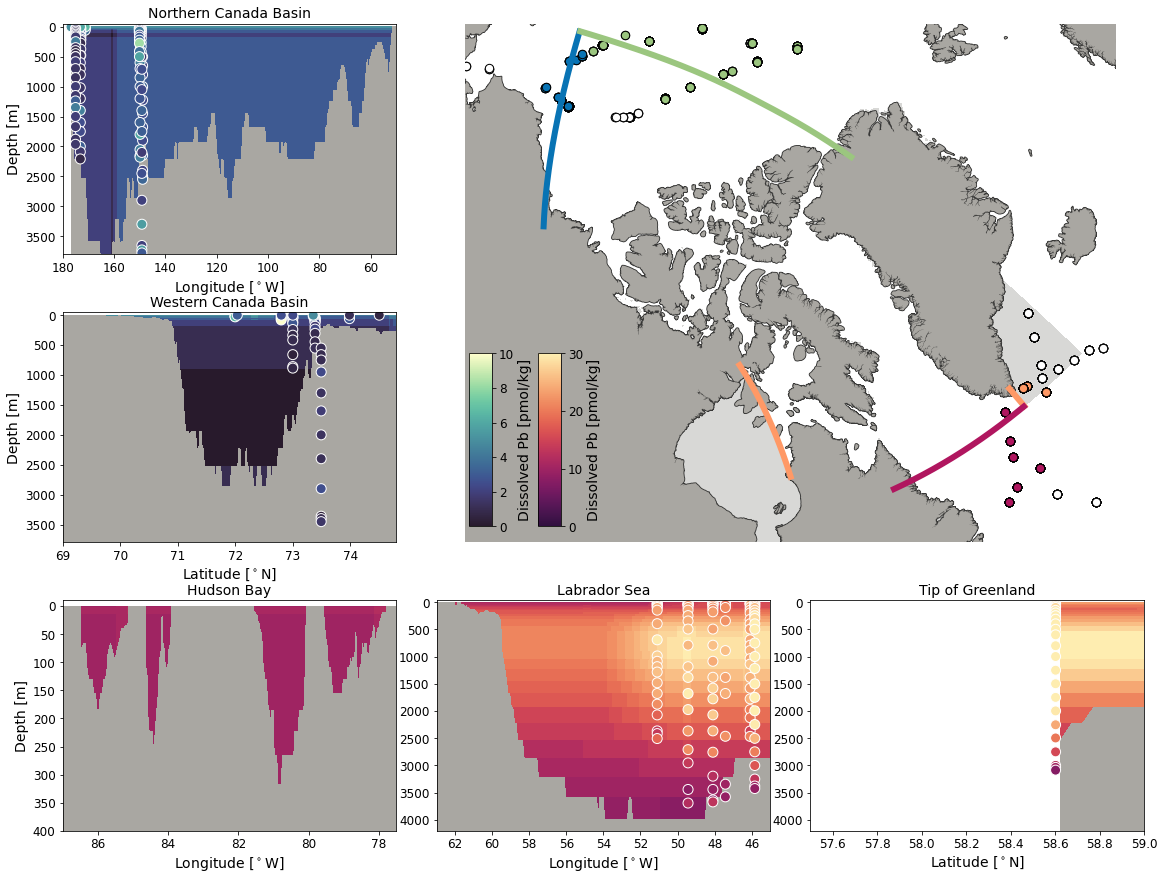

In [14]:
fig = plt.figure(figsize=(16,12))
ax1 = plt.subplot2grid((3, 3), (0, 1), rowspan=2, colspan=2) # map
ax2 = plt.subplot2grid((3, 3), (0, 0)) # left upper
ax3 = plt.subplot2grid((3, 3), (1, 0)) # left middle
ax4 = plt.subplot2grid((3, 3), (2, 0)) # left bottom
ax5 = plt.subplot2grid((3, 3), (2, 1)) # bottom middle
ax6 = plt.subplot2grid((3, 3), (2, 2)) # bottom right

axes = [ax2, ax3, ax4, ax5, ax6]

# ----------- Map ------------------------------------------------
proj=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax1)
proj.drawcoastlines(color='#373736', linewidth=1.8)
proj.fillcontinents(color=land_color, lake_color=land_color, zorder=5)
ax1.set_frame_on(False)
x, y = proj(mesh_lon, mesh_lat)
proj.contourf(x, y, bathy_masked[0,:,:], colors=['#d8d8d6']) # land mask

# Domain boundaries: 
proj.plot(x[jmin:1136,680]   , y[jmin:1136,680]    , '-', c=color_sGR, lw=6, zorder=5); # southeastern Greenland
proj.plot(x[jmin,442:680]    , y[jmin,442:680]     , '-', c=color_sBB, lw=6, zorder=5); # southern Baffin Bay
proj.plot(x[jmax,392:imax-1] , y[jmax,392:imax-1]  , '-', c=color_wCB, lw=6, zorder=5); # western Canada Basin
proj.plot(x[1600:jmax,imax-1], y[1600:jmax,imax-1] , '-', c=color_nCB, lw=6, zorder=5); # northern Canada Basin
proj.plot(x[1190:1474,292]   , y[1190:1474,292]    , '-', c=color_wHB, lw=6, zorder=5); # Hudson Bay bdy

# Label station locations on map: Arctic Ocean
x_AO, y_AO = proj(AO_lons , AO_lats) 
proj.scatter(x_AO, y_AO, c='w', s=70, zorder=5, edgecolor='k')
proj.scatter(x_AO[(AO_lats > 80) & (AO_lons > -150)], \
             y_AO[(AO_lats > 80) & (AO_lons > -150)], \
             c=color_nCB, s=70, zorder=5, edgecolor='k')
proj.scatter(x_AO[(AO_lats > 75) & (AO_lons < -150) & (AO_lons > -179)], \
             y_AO[(AO_lats > 75) & (AO_lons < -150) & (AO_lons > -179)], \
             c=color_nCB, s=70, zorder=5, edgecolor='k')
proj.scatter(x_AO[(AO_lats > 71) & (AO_lats < 75) & (AO_lons < -150)], \
             y_AO[(AO_lats > 71) & (AO_lats < 75) & (AO_lons < -150)], \
             c=color_wCB, s=70, zorder=5, edgecolor='k')

# Label station locations on map: North Atlantic
x_NA, y_NA = proj(mNA_lons, mNA_lats) 
proj.scatter(x_NA, y_NA, c='w', s=70, zorder=5, edgecolor='k')
proj.scatter(x_NA[(mNA_lats < 60) & (mNA_lats > 52) & (mNA_lons > -90) & (mNA_lons <-44)], \
             y_NA[(mNA_lats < 60) & (mNA_lats > 52) & (mNA_lons > -90) & (mNA_lons <-44)], \
             c=color_sBB, s=70, zorder=5, edgecolor='k')
proj.scatter(x_NA[(mNA_lats < 64) & (mNA_lats > 55) & (mNA_lons > -44) & (mNA_lons <-39)], \
             y_NA[(mNA_lats < 64) & (mNA_lats > 55) & (mNA_lons > -44) & (mNA_lons <-39)], \
             c=color_sGR, s=70, zorder=5, edgecolor='k')

# -----------  Boundary Condition subplots: ----------- 
# titles:
for ind, ax in enumerate(axes):
    ax.set_title(boundary_names[ind], fontsize=14)
    if ind < 3:
        ax.set_ylabel('Depth [m]', fontsize=14)
    if (ind == 1) or (ind == 4):
        ax.set_xlabel('Latitude [$^\circ$N]', fontsize=14)
    else:
        ax.set_xlabel('Longitude [$^\circ$W]', fontsize=14) 

vmin_CS1 = 0; vmax_CS1 = 10;
vmin_CS2 = 0; vmax_CS2 = 30;
CS1 = plot_BC(ax2, 'AO' , xlim=(180,50) , ylim=(3800,-50), vlim=(vmin_CS1, vmax_CS1))
CS1 = plot_BC(ax3, 'CB' , xlim=(69,74.8)  , ylim=(3800,-50), vlim=(vmin_CS1, vmax_CS1))
CS2 = plot_BC(ax4, 'HB' , xlim=(87,77.5)  , ylim=(400,-10), vlim=(vmin_CS2, vmax_CS2))
CS2 = plot_BC(ax5, 'BB' , xlim=(63,45)  , ylim=(4200,-30), vlim=(vmin_CS2, vmax_CS2))
CS2 = plot_BC(ax6, 'BBE', xlim=(57.5,59), ylim=(4200,-30), vlim=(vmin_CS2, vmax_CS2))
# CS1 = plot_BC(ax2, 'AO' , xlim=(180,50) , ylim=(500,-50), vlim=(vmin_CS1, vmax_CS1))
# CS1 = plot_BC(ax3, 'CB' , xlim=(69,74.8)  , ylim=(500,-50), vlim=(vmin_CS1, vmax_CS1))
# CS2 = plot_BC(ax4, 'HB' , xlim=(87,77.5)  , ylim=(400,-10), vlim=(vmin_CS2, vmax_CS2))
# CS2 = plot_BC(ax5, 'BB' , xlim=(63,45)  , ylim=(500,-30), vlim=(vmin_CS2, vmax_CS2))
# CS2 = plot_BC(ax6, 'BBE', xlim=(57.5,59), ylim=(500,-30), vlim=(vmin_CS2, vmax_CS2))


# ---------- Settings: --------------------------------
plt.tight_layout(pad=-0.1, w_pad=-0.5, h_pad=-0.1)

cbaxes1 = fig.add_axes([0.40, 0.40, 0.02, 0.2]) 
cbaxes2 = fig.add_axes([0.46, 0.40, 0.02, 0.2]) 
CBar1 = plt.colorbar(CS1, ax=ax1, cax=cbaxes1, orientation='vertical', ticks=[0,2,4,6,8,10,12,14,16])
CBar2 = plt.colorbar(CS2, ax=ax2, cax=cbaxes2, orientation='vertical', ticks=[0,10,20,30,40])
CBar1.ax.tick_params(labelsize=12) 
CBar2.ax.tick_params(labelsize=12) 
CBar1.set_label('Dissolved Pb [pmol/kg]', fontsize=14)
CBar2.set_label('Dissolved Pb [pmol/kg]', fontsize=14)

# Based on distance along boundary:

In [24]:
# Convert lat/lon to distance along transect:
def calc_distance(lats, lons):
    R = 6373.0 # approximate radius of earth in km

    lats_rad = [radians(l) for l in lats]
    lons_rad = [radians(l) for l in lons]

    dlon = [lon_step - lons_rad[0] for lon_step in lons_rad]
    dlat = [lat_step - lats_rad[0] for lat_step in lats_rad]

    distance = np.empty((len(dlon)))
    for i in range(0,len(dlon)):
        a = sin(dlat[i] / 2)**2 + cos(lats_rad[0]) * cos(lats_rad[i]) * sin(dlon[i] / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance[i] = R * c
        
    return distance

In [25]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [26]:
# Convert lat/lon to closest point on boundary:
def closest_bdy_point(lats, lons, bdy_lat, bdy_lon):

    bdy_ind = np.empty_like(lats)
    for stn in range(0,len(lats)):
        dist = haversine(lons[stn], lats[stn], bdy_lon, bdy_lat)
        if np.min(dist) > 500:
            bdy_ind[stn] = 0
        else:
            bdy_ind[stn] = np.argmin(dist)

    return bdy_ind

In [27]:
# Look at only one slice of the rimwidth thickness boundary:
N_distance  = calc_distance(dPb_N_lats[-1,:], dPb_N_lons[-1,:])
E_distance  = calc_distance(dPb_E_lats[::-1,-1], dPb_E_lons[::-1,-1])
S_distance  = calc_distance(dPb_S_lats[-1,:], dPb_S_lons[-1,:])
W_distance  = calc_distance(dPb_W_lats[::-1,-1], dPb_W_lons[::-1,-1])
SE_distance = calc_distance(dPb_SE_lats[:,-1], dPb_SE_lons[:,-1])

In [28]:
# Find index along boundary of the observations
AO_bdy_ind  = closest_bdy_point(AO_lats, AO_lons, dPb_E_lats[::-1,-1], dPb_E_lons[::,-1])
CB_bdy_ind  = closest_bdy_point(AO_lats, AO_lons, dPb_N_lats[-1,:], dPb_N_lons[-1,:])
BB_bdy_ind  = closest_bdy_point(mNA_lats, mNA_lons, dPb_S_lats[-1,:] , dPb_S_lons[-1,:])
BBE_bdy_ind = closest_bdy_point(mNA_lats, mNA_lons, dPb_SE_lats[:,-1], dPb_SE_lons[:,-1])

AO_obs_distance  = np.array([E_distance[int(ind)] for ind in AO_bdy_ind])
CB_obs_distance  = np.array([N_distance[int(ind)] for ind in CB_bdy_ind])
BB_obs_distance  = np.array([S_distance[int(ind)] for ind in BB_bdy_ind])
BBE_obs_distance = np.array([SE_distance[int(ind)] for ind in BBE_bdy_ind])

In [20]:
# Mask stations that are farther than 500 km from the boundary
AO_obs_distance[AO_obs_distance == 0] = np.nan
CB_obs_distance[CB_obs_distance == 0] = np.nan
BB_obs_distance[BB_obs_distance == 0] = np.nan
BBE_obs_distance[BBE_obs_distance == 0] = np.nan

In [21]:
AO_bdy_lats = np.ma.masked_where(np.isnan(AO_obs_distance), AO_lats)
AO_bdy_lons = np.ma.masked_where(np.isnan(AO_obs_distance), AO_lons)
CB_bdy_lats = np.ma.masked_where(np.isnan(CB_obs_distance), AO_lats)
CB_bdy_lons = np.ma.masked_where(np.isnan(CB_obs_distance), AO_lons)
BB_bdy_lats = np.ma.masked_where(np.isnan(BB_obs_distance), mNA_lats)
BB_bdy_lons = np.ma.masked_where(np.isnan(BB_obs_distance), mNA_lons)
BBE_bdy_lats = np.ma.masked_where(np.isnan(BBE_obs_distance), mNA_lats)
BBE_bdy_lons = np.ma.masked_where(np.isnan(BBE_obs_distance), mNA_lons)

In [22]:
def plot_BC(axis, bdy_distance, dPb, bathy, obs_distance, obs_depths, obs_dPb, ylim=(4000, -50), vlim=(0,25), cmap=cmocean.cm.deep_r):    
    axis.invert_yaxis()
    axis.set_ylim([ylim[0], ylim[1]])
    axis.tick_params(axis='both', which='major', labelsize=12)
    
    # plot model boundary condition:
    xx, zz = np.meshgrid(bdy_distance, depths)
    CB = axis.pcolor(xx, zz, dPb*1e12, vmin=vlim[0], vmax=vlim[1], cmap=cmap)
    axis.contourf(xx, zz, bathy, cmap=matplotlib.colors.ListedColormap([land_color]))
        
    # superimpose observations:
    try:
        axis.scatter(obs_distance, obs_depths, c=obs_dPb, vmin=vlim[0], vmax=vlim[1], edgecolor='w', cmap=cmap, s=100)
    except:
        pass

    return CB

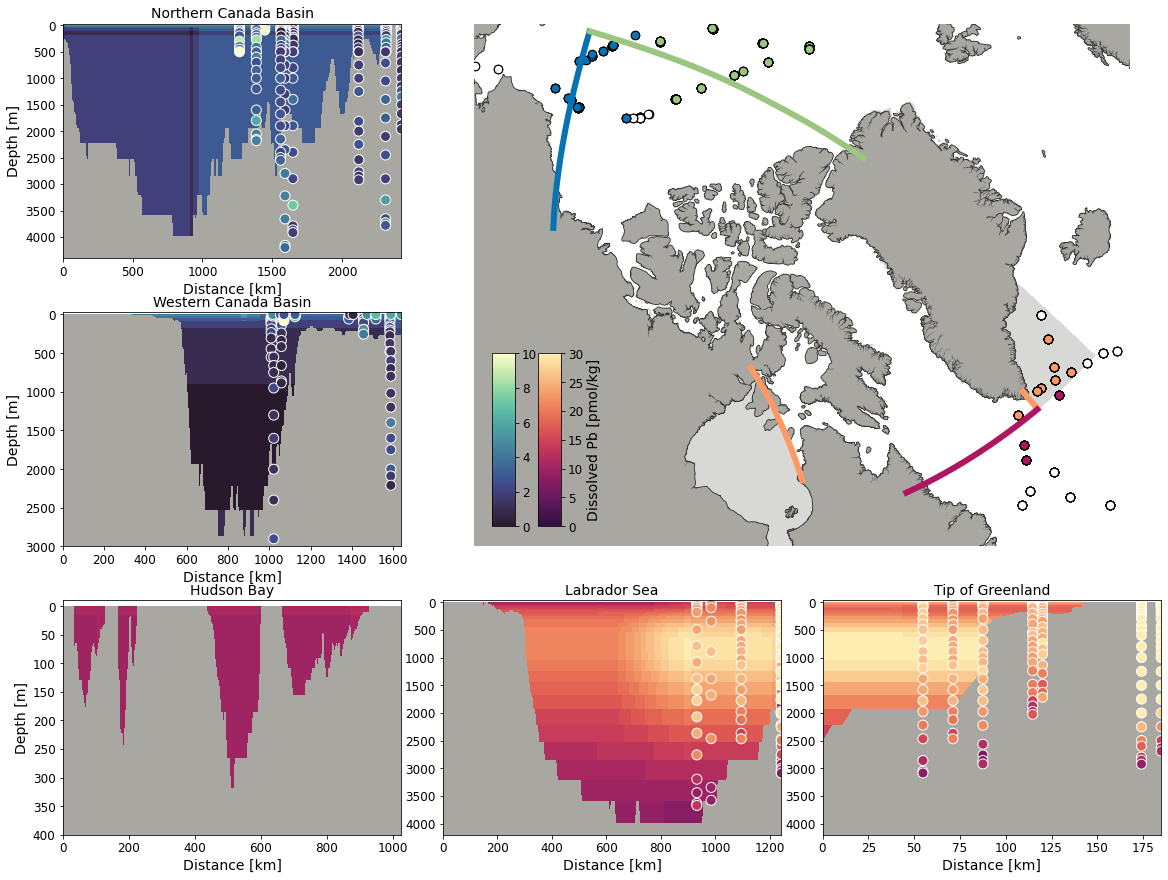

In [23]:
fig = plt.figure(figsize=(16,12))
ax1 = plt.subplot2grid((3, 3), (0, 1), rowspan=2, colspan=2) # map
ax2 = plt.subplot2grid((3, 3), (0, 0)) # left upper
ax3 = plt.subplot2grid((3, 3), (1, 0)) # left middle
ax4 = plt.subplot2grid((3, 3), (2, 0)) # left bottom
ax5 = plt.subplot2grid((3, 3), (2, 1)) # bottom middle
ax6 = plt.subplot2grid((3, 3), (2, 2)) # bottom right

axes = [ax2, ax3, ax4, ax5, ax6]

# ----------- Map ------------------------------------------------
proj=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax1)
proj.drawcoastlines(color='#373736', linewidth=1.8)
proj.fillcontinents(color=land_color, lake_color=land_color, zorder=5)
ax1.set_frame_on(False)
x, y = proj(mesh_lon, mesh_lat)
proj.contourf(x, y, bathy_masked[0,:,:], colors=['#d8d8d6']) # land mask

# Domain boundaries: 
proj.plot(x[jmin:1136,680]   , y[jmin:1136,680]    , '-', c=color_sGR, lw=6, zorder=5); # southeastern Greenland
proj.plot(x[jmin,442:680]    , y[jmin,442:680]     , '-', c=color_sBB, lw=6, zorder=5); # southern Baffin Bay
proj.plot(x[jmax,392:imax-1] , y[jmax,392:imax-1]  , '-', c=color_wCB, lw=6, zorder=5); # western Canada Basin
proj.plot(x[1600:jmax,imax-1], y[1600:jmax,imax-1] , '-', c=color_nCB, lw=6, zorder=5); # northern Canada Basin
proj.plot(x[1190:1474,292]   , y[1190:1474,292]    , '-', c=color_wHB, lw=6, zorder=5); # Hudson Bay bdy

# Label stations shown on the boundary subplots on the central map:
x_all1, y_all1 = proj(AO_lons, AO_lats)
x_all2, y_all2 = proj(mNA_lons, mNA_lats)
x_AO, y_AO   = proj(AO_bdy_lons, AO_bdy_lats)
x_CB, y_CB   = proj(CB_bdy_lons, CB_bdy_lats)
x_BB, y_BB   = proj(BB_bdy_lons, BB_bdy_lats)
x_BBE, y_BBE = proj(BBE_bdy_lons, BBE_bdy_lats)
proj.scatter(x_all1, y_all1, c='w', s=70, zorder=5, edgecolor='k')
proj.scatter(x_all2, y_all2, c='w', s=70, zorder=5, edgecolor='k')
proj.scatter(x_AO, y_AO, c=color_nCB, s=70, zorder=5, edgecolor='k')
proj.scatter(x_CB, y_CB, c=color_wCB, s=70, zorder=5, edgecolor='k')
proj.scatter(x_BB, y_BB, c=color_sBB, s=70, zorder=5, edgecolor='k')
proj.scatter(x_BBE, y_BBE, c=color_sGR, s=70, zorder=5, edgecolor='k')

# -----------  Boundary Condition subplots: ----------- 
# titles:
for ind, ax in enumerate(axes):
    ax.set_title(boundary_names[ind], fontsize=14)
    ax.set_xlabel('Distance [km]', fontsize=14)
    if ind < 3:
        ax.set_ylabel('Depth [m]', fontsize=14)

vmin_CS1 = 0; vmax_CS1 = 10;
vmin_CS2 = 0; vmax_CS2 = 30;
CS1 = plot_BC(ax2, E_distance, dPb_E[:,-1,::-1], dPb_E_mdepths[:,::-1,-1], \
              AO_obs_distance, AO_depths, AO_dPb, \
              ylim=(4400,-30), vlim=(vmin_CS1,vmax_CS1))
CS1 = plot_BC(ax3, N_distance, dPb_N[:,-1,:], dPb_N_mdepths[:,-1,:], \
              CB_obs_distance, AO_depths, AO_dPb, \
              ylim=(3000,-30), vlim=(vmin_CS1,vmax_CS1))
CS2 = plot_BC(ax4, W_distance, dPb_W[:,-1,::-1], dPb_W_mdepths[:,::-1,-1], \
              np.empty([]), np.empty([]), np.empty([]), \
              ylim=(400,-10), vlim=(vmin_CS2,vmax_CS2), cmap=cmocean.cm.matter_r)
CS2 = plot_BC(ax5, S_distance, dPb_S[:,-1,:], dPb_S_mdepths[:,-1,:], \
              BB_obs_distance, mNA_depths, mNA_Pb, \
              ylim=(4200,-30), vlim=(vmin_CS2,vmax_CS2), cmap=cmocean.cm.matter_r)
CS2 = plot_BC(ax6, SE_distance, dPb_SE[:,-1,:], dPb_SE_mdepths[:,:,-1], \
              BBE_obs_distance, mNA_depths, mNA_Pb, \
              ylim=(4200,-30), vlim=(vmin_CS2,vmax_CS2), cmap=cmocean.cm.matter_r)

# ---------- Settings: --------------------------------
plt.tight_layout(pad=-0.1, w_pad=-0.5, h_pad=-0.1)

cbaxes1 = fig.add_axes([0.42, 0.40, 0.02, 0.2]) 
cbaxes2 = fig.add_axes([0.46, 0.40, 0.02, 0.2]) 
CBar1 = plt.colorbar(CS1, ax=ax1, cax=cbaxes1, orientation='vertical', ticks=[0,2,4,6,8,10,12,14,16])
CBar2 = plt.colorbar(CS2, ax=ax2, cax=cbaxes2, orientation='vertical', ticks=[0,5,10,15,20,25,30,35,40])
CBar1.ax.tick_params(labelsize=12) 
CBar2.ax.tick_params(labelsize=12) 
CBar2.set_label('Dissolved Pb [pmol/kg]', fontsize=14)

In [ ]:
fig = plt.figure(figsize=(16,12))
ax1 = plt.subplot2grid((3, 3), (0, 1), rowspan=2, colspan=2) # map
ax2 = plt.subplot2grid((3, 3), (0, 0)) # left upper
ax3 = plt.subplot2grid((3, 3), (1, 0)) # left middle
ax4 = plt.subplot2grid((3, 3), (2, 0)) # left bottom
ax5 = plt.subplot2grid((3, 3), (2, 1)) # bottom middle
ax6 = plt.subplot2grid((3, 3), (2, 2)) # bottom right

axes = [ax2, ax3, ax4, ax5, ax6]

# ----------- Map ------------------------------------------------
proj=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax1)
proj.drawcoastlines(color='#373736', linewidth=1.8)
proj.fillcontinents(color=land_color, lake_color=land_color, zorder=5)
ax1.set_frame_on(False)
x, y = proj(mesh_lon, mesh_lat)
proj.contourf(x, y, bathy_masked[0,:,:], colors=['#d8d8d6']) # land mask

# Domain boundaries: 
proj.plot(x[jmin:1136,680]   , y[jmin:1136,680]    , '-', c=color_sGR, lw=6, zorder=5); # southeastern Greenland
proj.plot(x[jmin,442:680]    , y[jmin,442:680]     , '-', c=color_sBB, lw=6, zorder=5); # southern Baffin Bay
proj.plot(x[jmax,392:imax-1] , y[jmax,392:imax-1]  , '-', c=color_wCB, lw=6, zorder=5); # western Canada Basin
proj.plot(x[1600:jmax,imax-1], y[1600:jmax,imax-1] , '-', c=color_nCB, lw=6, zorder=5); # northern Canada Basin
proj.plot(x[1190:1474,292]   , y[1190:1474,292]    , '-', c=color_wHB, lw=6, zorder=5); # Hudson Bay bdy

# Label stations shown on the boundary subplots on the central map:
x_all1, y_all1 = proj(AO_lons, AO_lats)
x_all2, y_all2 = proj(mNA_lons, mNA_lats)
x_AO, y_AO   = proj(AO_bdy_lons, AO_bdy_lats)
x_CB, y_CB   = proj(CB_bdy_lons, CB_bdy_lats)
x_BB, y_BB   = proj(BB_bdy_lons, BB_bdy_lats)
x_BBE, y_BBE = proj(BBE_bdy_lons, BBE_bdy_lats)
proj.scatter(x_all1, y_all1, c='w', s=70, zorder=5, edgecolor='k')
proj.scatter(x_all2, y_all2, c='w', s=70, zorder=5, edgecolor='k')
proj.scatter(x_AO, y_AO, c=color_nCB, s=70, zorder=5, edgecolor='k')
proj.scatter(x_CB, y_CB, c=color_wCB, s=70, zorder=5, edgecolor='k')
proj.scatter(x_BB, y_BB, c=color_sBB, s=70, zorder=5, edgecolor='k')
proj.scatter(x_BBE, y_BBE, c=color_sGR, s=70, zorder=5, edgecolor='k')

# -----------  Boundary Condition subplots: ----------- 
# titles:
for ind, ax in enumerate(axes):
    ax.set_title(boundary_names[ind], fontsize=14)
    ax.set_xlabel('Distance [km]', fontsize=14)
    if ind < 3:
        ax.set_ylabel('Depth [m]', fontsize=14)

vmin_CS1 = 0; vmax_CS1 = 10;
vmin_CS2 = 0; vmax_CS2 = 30;
CS1 = plot_BC(ax2, E_distance, dPb_E[:,-1,::-1], dPb_E_mdepths[:,::-1,-1], \
              AO_obs_distance, AO_depths, AO_dPb, \
              ylim=(300,-10), vlim=(vmin_CS1,vmax_CS1))
CS1 = plot_BC(ax3, N_distance, dPb_N[:,-1,:], dPb_N_mdepths[:,-1,:], \
              CB_obs_distance, AO_depths, AO_dPb, \
              ylim=(300,-10), vlim=(vmin_CS1,vmax_CS1))
CS2 = plot_BC(ax4, W_distance, dPb_W[:,-1,::-1], dPb_W_mdepths[:,::-1,-1], \
              np.empty([]), np.empty([]), np.empty([]), \
              ylim=(400,-10), vlim=(vmin_CS2,vmax_CS2), cmap=cmocean.cm.matter_r)
CS2 = plot_BC(ax5, S_distance, dPb_S[:,-1,:], dPb_S_mdepths[:,-1,:], \
              BB_obs_distance, mNA_depths, mNA_Pb, \
              ylim=(300,-10), vlim=(vmin_CS2,vmax_CS2), cmap=cmocean.cm.matter_r)
CS2 = plot_BC(ax6, SE_distance, dPb_SE[:,-1,:], dPb_SE_mdepths[:,:,-1], \
              BBE_obs_distance, mNA_depths, mNA_Pb, \
              ylim=(300,-10), vlim=(vmin_CS2,vmax_CS2), cmap=cmocean.cm.matter_r)

# ---------- Settings: --------------------------------
plt.tight_layout(pad=-0.1, w_pad=-0.5, h_pad=-0.1)

cbaxes1 = fig.add_axes([0.42, 0.40, 0.02, 0.2]) 
cbaxes2 = fig.add_axes([0.46, 0.40, 0.02, 0.2]) 
CBar1 = plt.colorbar(CS1, ax=ax1, cax=cbaxes1, orientation='vertical', ticks=[0,2,4,6,8,10,12,14,16])
CBar2 = plt.colorbar(CS2, ax=ax2, cax=cbaxes2, orientation='vertical', ticks=[0,5,10,15,20,25,30,35,40])
CBar1.ax.tick_params(labelsize=12) 
CBar2.ax.tick_params(labelsize=12) 
CBar2.set_label('Dissolved Pb [pmol/kg]', fontsize=14)